<a href="https://colab.research.google.com/github/DCODE-ARMY/Face-Detection-and-Recognition/blob/main/Face_Detection_ND_Spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
import numpy as np
import pandas as pd
import cv2 as cv


In [ ]:
# @title References for Face Detection Models { display-mode: "form" }

In [ ]:
'''
#ArcFace
1. https://medium.com/@ichigo.v.gen12/arcface-architecture-and-practical-example-how-to-calculate-the-face-similarity-between-
images-183896a35957#:~:text=The%20image%20from%20original%20paper,%2Dclass(others)%20discrepancy.

2. https://github.com/rcmalli/keras-vggface

# FaceNet
https://github.com/nyoki-mtl/keras-facenet/tree/master?tab=readme-ov-file

 '''

In [ ]:
# !git clone https://github.com/deepinsight/insightface.git


In [ ]:
!pip install tensorflow mtcnn

In [ ]:
# !wget https://github.com/nyoki-mtl/keras-facenet/blob/master/model/facenet_keras.h5?raw=true -O facenet_keras.h5
# !gdown --id 1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model

# # Load the pre-trained Facenet model
# model = load_model('/content/drive/MyDrive/model/keras-facenet/weights/facenet_keras_weights.h5')


In [1]:
# Most Recent One (Suggested)
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface

!pip install Keras-Applications
!pip install mtcnn

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-gi7hnsun
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-gi7hnsun
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=3f8d1e40e08f4c4371118c5f6dbf23c601e19007c971d61b10df54f3be610052
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfpqek3a/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.9 MB/s eta 0:00:00


In [2]:
import keras
keras.__version__

'2.15.0'

In [ ]:
'''
Note: We are currently using tensorflow 2.15. The VGGFace is supported only till 2.12.
we should revert back to 2.12.

https://github.com/rcmalli/keras-vggface/issues/97

'''

!pip uninstall keras
!pip install keras==2.12

In [1]:
import keras
keras.__version__

'2.12.0'

In [2]:
from keras import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(model='senet50',include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
model=vgg_features


104944616/104944616 [==============================] - 2s 0us/step


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.9 MB/s eta 0:00:00


In [3]:
from mtcnn import MTCNN
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt

# Function to extract a single face from an image
def extract_face(filename, required_size=(224, 224)):
    # Load image from file
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)

    # Create the detector, using default weights
    detector = MTCNN()
    # Detect faces in the image
    results = detector.detect_faces(pixels)
    if not results:
        raise Exception("No face detected")

    # Extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # Extract the face
    face = pixels[y1:y2, x1:x2]
    # Resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# Function to get embeddings for a list of images
def get_embeddings(filenames):
    faces = [extract_face(f) for f in filenames]
    samples = np.asarray(faces, 'float32')
    samples = (samples - 127.5) / 128.0  # Normalize the images
    embeddings = model.predict(samples)
    return embeddings


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 354ms/step
>face is NOT a Match (0.000 > 0.000)
0.00035941600799560547 Rain1
>face is NOT a Match (0.001 > 0.000)
0.0014567971229553223 Raina2
>face is NOT a Match (0.000 > 0.000)
0.0004366636276245117 Dhoni1
0.00020056962966918945 Dhoni2
>face is a Match (0.000 <= 0.000)


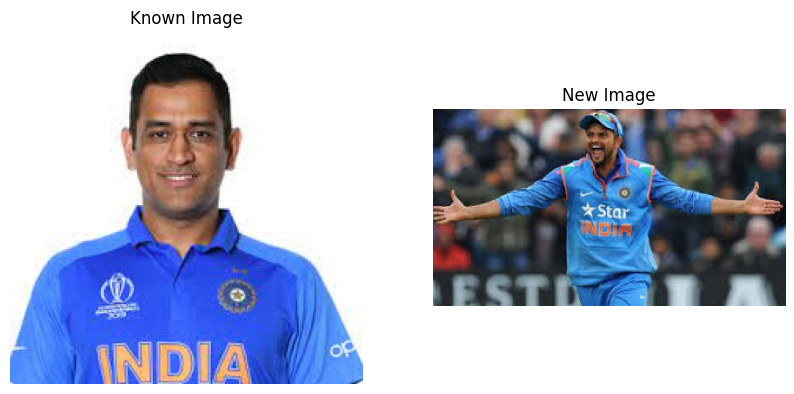

In [4]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from PIL import Image
import numpy as np

# Function to determine if two embeddings match
def is_match(known_embedding, candidate_embedding, known_image, candidate_image, known_names,thresh=0.0003):
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print(score,known_names)
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
        visualize_match(known_image, candidate_image)
        return True
    else:
        print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
        print(score,known_names)
        return False

# Function to visualize two images side by side
def visualize_match(img1_path, img2_path):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Known Image')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('New Image')

    plt.show()

# Example usage with multiple people
known_faces = ["/content/im_1.jpg", '/content/im_2.jpg', '/content/im_3.jpg', '/content/im_4.jpg']
known_names = ['Rain1', 'Raina2', 'Dhoni1', 'Dhoni2']

# Get embeddings for known faces
known_embeddings = get_embeddings(known_faces)

# Load a new image and get its embedding
new_face = '/content/im_5.jpg'
new_embedding = get_embeddings([new_face])[0]

# Compare the new embedding with known embeddings
for i in range(len(known_embeddings)):
    if is_match(known_embeddings[i], new_embedding, known_faces[i], new_face,known_names[i]):
        print(f'The new face matches with {known_names[i]}')
        break


In [ ]:
train_x_files=["/content/im_8.jpg","/content/im_1.jpg",  '/content/im_5.jpg',"/content/im_2.jpg","/content/im_4.jpg", "/content/im_7.jpg",]
train_y_files= ['Kholi','Raina',  'Dhoni','Raina','Dhoni','Kholi',]
test_x_files=['/content/im_3.jpg','/content/im_6.jpg',"/content/im_9.jpg"]
test_y_files=['Raina','Dhoni','Kholi']


train_x=get_embeddings(train_x_files)
test_x= get_embeddings(test_x_files)


In [ ]:
train_x_files=["/content/im_1.jpg",  '/content/im_5.jpg', "/content/im_7.jpg",]
train_y_files= ['Raina',  'Dhoni','Kholi',]
test_x_files=["/content/im_9.jpg",'/content/im_2.jpg','/content/im_6.jpg',]
test_y_files=['Kholi','Raina','Dhoni',]


train_x=get_embeddings(train_x_files)
test_x= get_embeddings(test_x_files)

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import load_model
from PIL import Image


In [50]:
train_y= np.asarray(train_y_files)
test_y=np.asarray(test_y_files)
print(train_y)
print(test_y)




['Raina' 'Dhoni' 'Kholi']
['Kholi' 'Raina' 'Dhoni']


In [51]:
a=LabelEncoder()
train_y=a.fit_transform(train_y_files)
test_y=a.fit_transform(test_y_files)
print(train_y,test_y)

[2 0 1] [1 2 0]


In [52]:
svc_model = SVC(kernel='rbf', probability=True)
svc_model.fit(train_x, train_y)

SVC(probability=True)

In [47]:
def visualize_match(img1_path,img1_name, img2_path,img2_name):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('True : {}'.format(img1_name))

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Predicted : {}'.format(img2_name))


Accuracy: 100.00%
True: Kholi, Predicted: Kholi
True: Raina, Predicted: Raina
True: Dhoni, Predicted: Dhoni


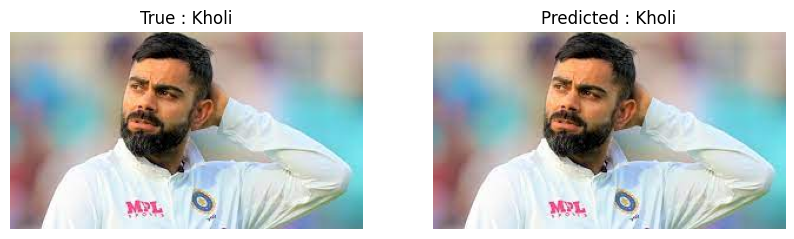

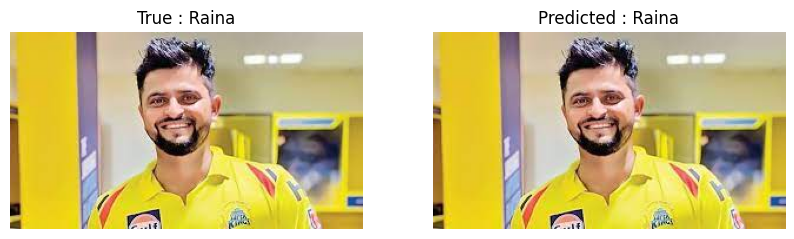

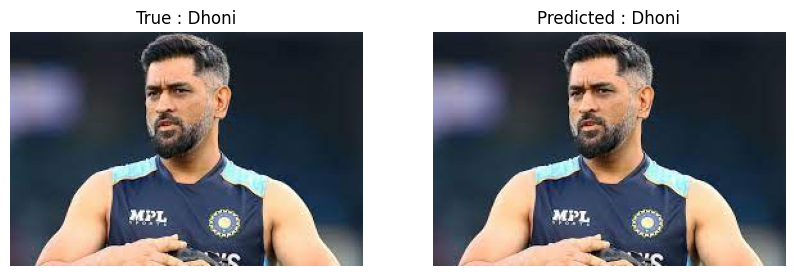

In [53]:
y_pred_enc = svc_model.predict(test_x)
y_pred = a.inverse_transform(y_pred_enc)

# Calculate accuracy
accuracy = accuracy_score(test_y_files, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optional: Display some results
for i in range(len(test_x)):
    visualize_match(img1_path= test_x_files[i], img1_name=test_y_files[i], img2_path=test_x_files[i],img2_name=y_pred[i])
    print(f'True: {test_y_files[i]}, Predicted: {y_pred[i]}')



In [ ]:
# @title #Note

In [ ]:
# accuracy is greatly influenced by beard